# Spam Email Detection

Goal: Detect spam messages<br>
Model: KNN/ Logistic Regression/ Decision Tree/ XGBoost/ Support Vector Classifier/ Deep Neural Network

The general task in this project is to build two different models for detecting spam messages:<br>
(i) The best possible model in terms of the overall predictive accuracy (i.e., not taking any cost information into account)<br>
(ii) The best cost-sensitive classification model in terms of the average misclassification cost

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn import linear_model
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score, roc_auc_score
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
data = pd.read_csv("spambase.data", header=None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4601 non-null   float64
 1   1       4601 non-null   float64
 2   2       4601 non-null   float64
 3   3       4601 non-null   float64
 4   4       4601 non-null   float64
 5   5       4601 non-null   float64
 6   6       4601 non-null   float64
 7   7       4601 non-null   float64
 8   8       4601 non-null   float64
 9   9       4601 non-null   float64
 10  10      4601 non-null   float64
 11  11      4601 non-null   float64
 12  12      4601 non-null   float64
 13  13      4601 non-null   float64
 14  14      4601 non-null   float64
 15  15      4601 non-null   float64
 16  16      4601 non-null   float64
 17  17      4601 non-null   float64
 18  18      4601 non-null   float64
 19  19      4601 non-null   float64
 20  20      4601 non-null   float64
 21  21      4601 non-null   float64
 22  

In [4]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1


## EDA

In [18]:
# Imbalance data detected
p=data.iloc[:,-1].value_counts()/data.shape[0]*100
print(f'spam email proportion: {p[1]}')
print(f'non-spam email proportion: {p[0]}')

spam email proportion: 39.404477287546186
non-spam email proportion: 60.59552271245382


## Train-Test Split

In [19]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:57], data.iloc[:, -1], test_size=0.2, random_state=0)

## Use oversampling to fix imbalance problem

In [24]:
oversample=SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train = X_train.astype(int)
y_train = y_train.astype(int)

## Data Normalization

In [83]:
# scale features
scaler = StandardScaler()
X_train_std =scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

## Nested Grid Search CV to find the best model

### (i) the best possible model in terms of the overall predictive accuracy

In [20]:
inner_cv = KFold(n_splits=5,shuffle = True,random_state = 1)
outer_cv = KFold(n_splits=5,shuffle = True,random_state = 1)

#KNN
knn_grid ={
"weights" : ["uniform", "distance"], "n_neighbors": range(1,20)
}

knn=neighbors.KNeighborsClassifier()
knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv)
knn_score = cross_val_score(knn_clf,X=X_train_std, y=y_train, cv=outer_cv, scoring="accuracy")
knn_score.mean()

0.9165760869565217

In [22]:
# logistic regression
lr = linear_model.LogisticRegression()
lr_grid ={
"C": [0.001,0.01,0.1,1,10,100,1000], "max_iter":[10000,100000]
}
lr_clf = GridSearchCV(estimator=lr, param_grid=lr_grid, cv=inner_cv)
lr_score = cross_val_score(lr_clf,X=X_train_std, y=y_train, cv=outer_cv, scoring="accuracy")
lr_score.mean()

0.9288043478260869

In [24]:
# decision tree
dt = tree.DecisionTreeClassifier()
dt_grid ={"max_depth" : [3,6,9], 
    "max_leaf_nodes": [5,10,15,20], 
    "min_samples_leaf": [5,10,15]}
dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=inner_cv)
dt_score = cross_val_score(dt_clf,X=X_train, y=y_train, cv=outer_cv, scoring="accuracy")
dt_score.mean()

0.902445652173913

In [26]:
# SVM
svc = SVC()

svc_grid ={ "gamma":[0.001,0.1,1,10,100], 
           "C": [0.001,0.01,0.1,1,10]}
svc_clf = GridSearchCV(estimator=svc, param_grid=svc_grid, cv=inner_cv)
svc_score = cross_val_score(svc_clf,X=X_train_std, y=y_train, cv=outer_cv, scoring="accuracy")
svc_score.mean()

0.9266304347826088

In [28]:
# XGBoost
xgb1 = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
xgb1_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
xgb1_clf = GridSearchCV(estimator=xgb1, param_grid=xgb1_grid, cv=inner_cv)
xgb1_score = cross_val_score(xgb1_clf,X=X_train_std, y=y_train, cv=outer_cv, scoring="accuracy")
xgb1_score.mean()

0.9532608695652174

In [34]:
# Neural Network
def create_model(activation='relu'):
    model = Sequential()
    model.add(Dense(units = 128, activation = activation))
    model.add(Dense(units = 64, activation = activation))
    model.add(Dense(units = 32, activation = activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nn = KerasClassifier(build_fn = create_model)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,50,100]
# Make a dictionary of the grid search parameters
nn_grid = dict(batch_size = batch_size,epochs = epochs)

nn_clf = GridSearchCV(estimator=nn, param_grid=nn_grid, cv=inner_cv, scoring='accuracy')
res = nn_clf.fit(X_train_std, y_train)

Epoch 1/10
295/295 [==============================] - 1s 691us/step - loss: 0.2927 - accuracy: 0.8865
Epoch 2/10
295/295 [==============================] - 0s 653us/step - loss: 0.1803 - accuracy: 0.9351
Epoch 3/10
295/295 [==============================] - 0s 663us/step - loss: 0.1484 - accuracy: 0.9450
Epoch 4/10
295/295 [==============================] - 0s 651us/step - loss: 0.1308 - accuracy: 0.9514
Epoch 5/10
295/295 [==============================] - 0s 643us/step - loss: 0.1212 - accuracy: 0.9501
Epoch 6/10
295/295 [==============================] - 0s 643us/step - loss: 0.1065 - accuracy: 0.9613
Epoch 7/10
295/295 [==============================] - 0s 642us/step - loss: 0.0926 - accuracy: 0.9660
Epoch 8/10
295/295 [==============================] - 0s 645us/step - loss: 0.0837 - accuracy: 0.9704
Epoch 9/10
295/295 [==============================] - 0s 641us/step - loss: 0.0758 - accuracy: 0.9718
Epoch 10/10
23/23 [==============================] - 0s 473us/step
Epoch 1/10
295/

295/295 [==============================] - 0s 644us/step - loss: 0.1115 - accuracy: 0.9616
Epoch 7/50
295/295 [==============================] - 0s 648us/step - loss: 0.1084 - accuracy: 0.9654
Epoch 8/50
295/295 [==============================] - 0s 964us/step - loss: 0.0905 - accuracy: 0.9688
Epoch 9/50
295/295 [==============================] - 0s 866us/step - loss: 0.0841 - accuracy: 0.9691
Epoch 10/50
295/295 [==============================] - 0s 758us/step - loss: 0.0772 - accuracy: 0.9704
Epoch 11/50
295/295 [==============================] - 0s 721us/step - loss: 0.0840 - accuracy: 0.9698
Epoch 12/50
295/295 [==============================] - 0s 839us/step - loss: 0.0621 - accuracy: 0.9779
Epoch 13/50
295/295 [==============================] - 0s 666us/step - loss: 0.0634 - accuracy: 0.9783
Epoch 14/50
295/295 [==============================] - 0s 794us/step - loss: 0.0615 - accuracy: 0.9817
Epoch 15/50
295/295 [==============================] - 0s 663us/step - loss: 0.0485 - ac

295/295 [==============================] - 0s 647us/step - loss: 0.0586 - accuracy: 0.9789
Epoch 14/100
295/295 [==============================] - 0s 650us/step - loss: 0.0495 - accuracy: 0.9813
Epoch 15/100
295/295 [==============================] - 0s 653us/step - loss: 0.0463 - accuracy: 0.9840
Epoch 16/100
295/295 [==============================] - 0s 644us/step - loss: 0.0455 - accuracy: 0.9854
Epoch 17/100
295/295 [==============================] - 0s 648us/step - loss: 0.0495 - accuracy: 0.9834
Epoch 18/100
295/295 [==============================] - 0s 647us/step - loss: 0.0386 - accuracy: 0.9881
Epoch 19/100
295/295 [==============================] - 0s 646us/step - loss: 0.0519 - accuracy: 0.9861
Epoch 20/100
295/295 [==============================] - 0s 642us/step - loss: 0.0450 - accuracy: 0.9854
Epoch 21/100
295/295 [==============================] - 0s 643us/step - loss: 0.0343 - accuracy: 0.9895
Epoch 22/100
295/295 [==============================] - 0s 647us/step - loss:

295/295 [==============================] - 0s 652us/step - loss: 0.0173 - accuracy: 0.9942
Epoch 70/100
295/295 [==============================] - 0s 664us/step - loss: 0.0135 - accuracy: 0.9952
Epoch 71/100
295/295 [==============================] - 0s 645us/step - loss: 0.0128 - accuracy: 0.9946
Epoch 72/100
295/295 [==============================] - 0s 642us/step - loss: 0.0123 - accuracy: 0.9959
Epoch 73/100
295/295 [==============================] - 0s 643us/step - loss: 0.0141 - accuracy: 0.9959
Epoch 74/100
295/295 [==============================] - 0s 651us/step - loss: 0.0294 - accuracy: 0.9905
Epoch 75/100
295/295 [==============================] - 0s 647us/step - loss: 0.0206 - accuracy: 0.9939
Epoch 76/100
295/295 [==============================] - 0s 645us/step - loss: 0.0223 - accuracy: 0.9946
Epoch 77/100
295/295 [==============================] - 0s 646us/step - loss: 0.0124 - accuracy: 0.9963
Epoch 78/100
295/295 [==============================] - 0s 646us/step - loss:

295/295 [==============================] - 0s 657us/step - loss: 0.0311 - accuracy: 0.9888
Epoch 26/100
295/295 [==============================] - 0s 655us/step - loss: 0.0398 - accuracy: 0.9874
Epoch 27/100
295/295 [==============================] - 0s 654us/step - loss: 0.0362 - accuracy: 0.9885
Epoch 28/100
295/295 [==============================] - 0s 654us/step - loss: 0.0321 - accuracy: 0.9901
Epoch 29/100
295/295 [==============================] - 0s 653us/step - loss: 0.0215 - accuracy: 0.9932
Epoch 30/100
295/295 [==============================] - 0s 657us/step - loss: 0.0195 - accuracy: 0.9929
Epoch 31/100
295/295 [==============================] - 0s 654us/step - loss: 0.0241 - accuracy: 0.9922
Epoch 32/100
295/295 [==============================] - 0s 655us/step - loss: 0.0231 - accuracy: 0.9922
Epoch 33/100
295/295 [==============================] - 0s 653us/step - loss: 0.0240 - accuracy: 0.9925
Epoch 34/100
295/295 [==============================] - 0s 657us/step - loss:

Epoch 82/100
295/295 [==============================] - 0s 652us/step - loss: 0.0180 - accuracy: 0.9952
Epoch 83/100
295/295 [==============================] - 0s 652us/step - loss: 0.0186 - accuracy: 0.9942
Epoch 84/100
295/295 [==============================] - 0s 721us/step - loss: 0.0153 - accuracy: 0.9952
Epoch 85/100
295/295 [==============================] - 0s 703us/step - loss: 0.0090 - accuracy: 0.9980
Epoch 86/100
295/295 [==============================] - 0s 751us/step - loss: 0.0107 - accuracy: 0.9969
Epoch 87/100
295/295 [==============================] - 0s 709us/step - loss: 0.0091 - accuracy: 0.9969
Epoch 88/100
295/295 [==============================] - 0s 721us/step - loss: 0.0089 - accuracy: 0.9969
Epoch 89/100
295/295 [==============================] - 0s 651us/step - loss: 0.0319 - accuracy: 0.9918
Epoch 90/100
295/295 [==============================] - 0s 651us/step - loss: 0.0173 - accuracy: 0.9949
Epoch 91/100
295/295 [==============================] - 0s 650us

148/148 [==============================] - 0s 761us/step - loss: 0.0233 - accuracy: 0.9922
Epoch 38/50
148/148 [==============================] - 0s 768us/step - loss: 0.0194 - accuracy: 0.9935
Epoch 39/50
148/148 [==============================] - 0s 687us/step - loss: 0.0213 - accuracy: 0.9925
Epoch 40/50
148/148 [==============================] - 0s 693us/step - loss: 0.0183 - accuracy: 0.9939
Epoch 41/50
148/148 [==============================] - 0s 691us/step - loss: 0.0189 - accuracy: 0.9932
Epoch 42/50
148/148 [==============================] - 0s 691us/step - loss: 0.0200 - accuracy: 0.9912
Epoch 43/50
148/148 [==============================] - 0s 782us/step - loss: 0.0250 - accuracy: 0.9905
Epoch 44/50
148/148 [==============================] - 0s 751us/step - loss: 0.0206 - accuracy: 0.9932
Epoch 45/50
148/148 [==============================] - 0s 730us/step - loss: 0.0178 - accuracy: 0.9939
Epoch 46/50
148/148 [==============================] - 0s 700us/step - loss: 0.0164 -

148/148 [==============================] - 0s 732us/step - loss: 0.0150 - accuracy: 0.9946
Epoch 45/50
148/148 [==============================] - 0s 686us/step - loss: 0.0123 - accuracy: 0.9959
Epoch 46/50
148/148 [==============================] - 0s 691us/step - loss: 0.0500 - accuracy: 0.9844
Epoch 47/50
148/148 [==============================] - 0s 678us/step - loss: 0.0249 - accuracy: 0.9929
Epoch 48/50
148/148 [==============================] - 0s 719us/step - loss: 0.0138 - accuracy: 0.9935
Epoch 49/50
148/148 [==============================] - 0s 722us/step - loss: 0.0154 - accuracy: 0.9946
Epoch 50/50
23/23 [==============================] - 0s 548us/step
Epoch 1/100
148/148 [==============================] - 0s 768us/step - loss: 0.3236 - accuracy: 0.8767
Epoch 2/100
148/148 [==============================] - 0s 692us/step - loss: 0.1872 - accuracy: 0.9378
Epoch 3/100
148/148 [==============================] - 0s 679us/step - loss: 0.1549 - accuracy: 0.9419
Epoch 4/100
148/14

148/148 [==============================] - 0s 734us/step - loss: 0.0144 - accuracy: 0.9949
Epoch 51/100
148/148 [==============================] - 0s 697us/step - loss: 0.0164 - accuracy: 0.9939
Epoch 52/100
148/148 [==============================] - 0s 688us/step - loss: 0.0190 - accuracy: 0.9932
Epoch 53/100
148/148 [==============================] - 0s 688us/step - loss: 0.0194 - accuracy: 0.9935
Epoch 54/100
148/148 [==============================] - 0s 718us/step - loss: 0.0159 - accuracy: 0.9949
Epoch 55/100
148/148 [==============================] - 0s 705us/step - loss: 0.0308 - accuracy: 0.9905
Epoch 56/100
148/148 [==============================] - 0s 662us/step - loss: 0.0533 - accuracy: 0.9861
Epoch 57/100
148/148 [==============================] - 0s 692us/step - loss: 0.0296 - accuracy: 0.9901
Epoch 58/100
148/148 [==============================] - 0s 660us/step - loss: 0.0217 - accuracy: 0.9946
Epoch 59/100
148/148 [==============================] - 0s 667us/step - loss:

148/148 [==============================] - 0s 685us/step - loss: 0.1046 - accuracy: 0.9637
Epoch 7/100
148/148 [==============================] - 0s 691us/step - loss: 0.0936 - accuracy: 0.9677
Epoch 8/100
148/148 [==============================] - 0s 694us/step - loss: 0.0815 - accuracy: 0.9766
Epoch 9/100
148/148 [==============================] - 0s 691us/step - loss: 0.0771 - accuracy: 0.9755
Epoch 10/100
148/148 [==============================] - 0s 687us/step - loss: 0.0690 - accuracy: 0.9776
Epoch 11/100
148/148 [==============================] - 0s 691us/step - loss: 0.0674 - accuracy: 0.9796
Epoch 12/100
148/148 [==============================] - 0s 665us/step - loss: 0.0616 - accuracy: 0.9783
Epoch 13/100
148/148 [==============================] - 0s 697us/step - loss: 0.0543 - accuracy: 0.9813
Epoch 14/100
148/148 [==============================] - 0s 691us/step - loss: 0.0485 - accuracy: 0.9840
Epoch 15/100
148/148 [==============================] - 0s 683us/step - loss: 0.

148/148 [==============================] - 0s 691us/step - loss: 0.0153 - accuracy: 0.9959
Epoch 63/100
148/148 [==============================] - 0s 686us/step - loss: 0.0142 - accuracy: 0.9956
Epoch 64/100
148/148 [==============================] - 0s 683us/step - loss: 0.0107 - accuracy: 0.9969
Epoch 65/100
148/148 [==============================] - 0s 682us/step - loss: 0.0098 - accuracy: 0.9963
Epoch 66/100
148/148 [==============================] - 0s 693us/step - loss: 0.0105 - accuracy: 0.9966
Epoch 67/100
148/148 [==============================] - 0s 681us/step - loss: 0.0109 - accuracy: 0.9963
Epoch 68/100
148/148 [==============================] - 0s 695us/step - loss: 0.0112 - accuracy: 0.9959
Epoch 69/100
148/148 [==============================] - 0s 687us/step - loss: 0.0130 - accuracy: 0.9959
Epoch 70/100
148/148 [==============================] - 0s 681us/step - loss: 0.0163 - accuracy: 0.9946
Epoch 71/100
148/148 [==============================] - 0s 686us/step - loss:

74/74 [==============================] - 0s 726us/step - loss: 0.0349 - accuracy: 0.9891
Epoch 20/50
74/74 [==============================] - 0s 735us/step - loss: 0.0720 - accuracy: 0.9793
Epoch 21/50
74/74 [==============================] - 0s 719us/step - loss: 0.0515 - accuracy: 0.9834
Epoch 22/50
74/74 [==============================] - 0s 724us/step - loss: 0.0404 - accuracy: 0.9854
Epoch 23/50
74/74 [==============================] - 0s 722us/step - loss: 0.0347 - accuracy: 0.9885
Epoch 24/50
74/74 [==============================] - 0s 723us/step - loss: 0.0324 - accuracy: 0.9898
Epoch 25/50
74/74 [==============================] - 0s 767us/step - loss: 0.0255 - accuracy: 0.9918
Epoch 26/50
74/74 [==============================] - 0s 803us/step - loss: 0.0298 - accuracy: 0.9918
Epoch 27/50
74/74 [==============================] - 0s 805us/step - loss: 0.0377 - accuracy: 0.9888
Epoch 28/50
74/74 [==============================] - 0s 782us/step - loss: 0.0333 - accuracy: 0.9895
Ep

74/74 [==============================] - 0s 743us/step - loss: 0.0264 - accuracy: 0.9925
Epoch 30/50
74/74 [==============================] - 0s 765us/step - loss: 0.0432 - accuracy: 0.9871
Epoch 31/50
74/74 [==============================] - 0s 731us/step - loss: 0.0215 - accuracy: 0.9935
Epoch 32/50
74/74 [==============================] - 0s 732us/step - loss: 0.0150 - accuracy: 0.9963
Epoch 33/50
74/74 [==============================] - 0s 732us/step - loss: 0.0152 - accuracy: 0.9956
Epoch 34/50
74/74 [==============================] - 0s 746us/step - loss: 0.0154 - accuracy: 0.9952
Epoch 35/50
74/74 [==============================] - 0s 735us/step - loss: 0.0157 - accuracy: 0.9946
Epoch 36/50
74/74 [==============================] - 0s 727us/step - loss: 0.0212 - accuracy: 0.9932
Epoch 37/50
74/74 [==============================] - 0s 745us/step - loss: 0.0225 - accuracy: 0.9932
Epoch 38/50
74/74 [==============================] - 0s 727us/step - loss: 0.0170 - accuracy: 0.9956
Ep

Epoch 39/100
74/74 [==============================] - 0s 735us/step - loss: 0.0186 - accuracy: 0.9949
Epoch 40/100
74/74 [==============================] - 0s 735us/step - loss: 0.0171 - accuracy: 0.9952
Epoch 41/100
74/74 [==============================] - 0s 727us/step - loss: 0.0163 - accuracy: 0.9949
Epoch 42/100
74/74 [==============================] - 0s 733us/step - loss: 0.0169 - accuracy: 0.9952
Epoch 43/100
74/74 [==============================] - 0s 729us/step - loss: 0.0158 - accuracy: 0.9949
Epoch 44/100
74/74 [==============================] - 0s 733us/step - loss: 0.0169 - accuracy: 0.9939
Epoch 45/100
74/74 [==============================] - 0s 726us/step - loss: 0.0207 - accuracy: 0.9932
Epoch 46/100
74/74 [==============================] - 0s 723us/step - loss: 0.0377 - accuracy: 0.9871
Epoch 47/100
74/74 [==============================] - 0s 732us/step - loss: 0.0470 - accuracy: 0.9881
Epoch 48/100
74/74 [==============================] - 0s 721us/step - loss: 0.0182

74/74 [==============================] - 0s 765us/step - loss: 0.0097 - accuracy: 0.9976
Epoch 99/100
74/74 [==============================] - 0s 751us/step - loss: 0.0141 - accuracy: 0.9959
Epoch 100/100
23/23 [==============================] - 0s 482us/step
Epoch 1/100
74/74 [==============================] - 0s 821us/step - loss: 0.3302 - accuracy: 0.8808
Epoch 2/100
74/74 [==============================] - 0s 782us/step - loss: 0.1889 - accuracy: 0.9344
Epoch 3/100
74/74 [==============================] - 0s 742us/step - loss: 0.1546 - accuracy: 0.9460
Epoch 4/100
74/74 [==============================] - 0s 736us/step - loss: 0.1309 - accuracy: 0.9548
Epoch 5/100
74/74 [==============================] - 0s 746us/step - loss: 0.1222 - accuracy: 0.9555
Epoch 6/100
74/74 [==============================] - 0s 742us/step - loss: 0.1086 - accuracy: 0.9623
Epoch 7/100
74/74 [==============================] - 0s 741us/step - loss: 0.1051 - accuracy: 0.9637
Epoch 8/100
74/74 [==============

Epoch 78/100
74/74 [==============================] - 0s 737us/step - loss: 0.0116 - accuracy: 0.9959
Epoch 79/100
74/74 [==============================] - 0s 741us/step - loss: 0.0125 - accuracy: 0.9969
Epoch 80/100
74/74 [==============================] - 0s 734us/step - loss: 0.0120 - accuracy: 0.9963
Epoch 81/100
74/74 [==============================] - 0s 723us/step - loss: 0.0209 - accuracy: 0.9946
Epoch 82/100
74/74 [==============================] - 0s 733us/step - loss: 0.0147 - accuracy: 0.9952
Epoch 83/100
74/74 [==============================] - 0s 733us/step - loss: 0.0141 - accuracy: 0.9959
Epoch 84/100
74/74 [==============================] - 0s 732us/step - loss: 0.0116 - accuracy: 0.9963
Epoch 85/100
74/74 [==============================] - 0s 991us/step - loss: 0.0148 - accuracy: 0.9946
Epoch 86/100
74/74 [==============================] - 0s 775us/step - loss: 0.0138 - accuracy: 0.9966
Epoch 87/100
74/74 [==============================] - 0s 771us/step - loss: 0.0266

In [35]:
print(res.best_score_, res.best_params_)

0.948641304347826 {'batch_size': 10, 'epochs': 10}


In [46]:
# Choose Neural Network as the best model
y_pred = nn_clf.predict(X_test_std)
print("Accuracy:{}".format(accuracy_score(y_test,y_pred)))
print(classification_report(y_test,y_pred))

29/29 [==============================] - 0s 585us/step
Accuracy:0.9326818675352877
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       538
           1       0.95      0.89      0.92       383

    accuracy                           0.93       921
   macro avg       0.94      0.93      0.93       921
weighted avg       0.93      0.93      0.93       921



### (ii) the best cost-sensitive classification model in terms of the average misclassification cost

In [116]:
# average misclassification cost is defined as 10*False postive + False negative as False positive is more coslty
def average_misclassification_cost(y_train,y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cost = 10*cm[0, 1] + cm[1, 0]
    return cost

mis_scorer = make_scorer(average_misclassification_cost, greater_is_better=True)

In [117]:
knn_grid ={
"weights" : ["uniform", "distance"], "n_neighbors": range(1,20)
}

knn=neighbors.KNeighborsClassifier()
knn_clf = GridSearchCV(estimator=knn, param_grid=knn_grid, cv=inner_cv, scoring=mis_scorer)
knn_score = cross_val_score(knn_clf,X=X_train_std, y=y_train, cv=outer_cv)
knn_score.mean()

367.8

In [107]:
# logistic regression
lr = linear_model.LogisticRegression()
lr_grid ={
"C": [0.001,0.01,0.1,1,10,100,1000], "max_iter":[10000,100000]
}
lr_clf = GridSearchCV(estimator=lr, param_grid=lr_grid, cv=inner_cv, scoring=mis_scorer)
lr_score = cross_val_score(lr_clf,X=X_train_std, y=y_train, cv=outer_cv)
lr_score.mean()

262.4

In [104]:
# decision tree
dt = tree.DecisionTreeClassifier()
dt_grid ={"max_depth" : [3,6,9], 
    "max_leaf_nodes": [5,10,15,20], 
    "min_samples_leaf": [5,10,15]}
dt_clf = GridSearchCV(estimator=dt, param_grid=dt_grid, cv=inner_cv, scoring=mis_scorer)
dt_score = cross_val_score(dt_clf,X=X_train, y=y_train, cv=outer_cv)
dt_score.mean()

440.0

In [108]:
# SVM
svc = SVC()

svc_grid ={ "gamma":[0.001,0.1,1,10,100], 
           "C": [0.001,0.01,0.1,1,10]}
svc_clf = GridSearchCV(estimator=svc, param_grid=svc_grid, cv=inner_cv, scoring=mis_scorer)
svc_score = cross_val_score(svc_clf,X=X_train_std, y=y_train, cv=outer_cv)
svc_score.mean()

286.0

In [148]:
# XGBoost
xgb1 = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
xgb1_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma':[0.01,0.5,1]
}
xgb1_clf = RandomizedSearchCV(estimator=xgb1, param_distributions=xgb1_grid, cv=inner_cv, scoring=mis_scorer)
xgb1_score = cross_val_score(xgb1_clf,X=X_train_std, y=y_train, cv=outer_cv)
xgb1_score.mean()

251.6

In [149]:
print("average misclassification cost")
print("knn:{}".format(knn_score.mean()/len(X_train)))
print("logistic regression:{}".format(lr_score.mean()/len(X_train)))
print("decision tree:{}".format(dt_score.mean()/len(X_train)))
print("SVM:{}".format(svc_score.mean()/len(X_train)))
print("XGBoost:{}".format(xgb1_score.mean()/len(X_train)))

average misclassification cost
knn:0.09994565217391305
logistic regression:0.07130434782608695
decision tree:0.11956521739130435
SVM:0.07771739130434782
XGBoost:0.0683695652173913


In [150]:
xgb1 = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
xgb1_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma':[0.01,0.5,1]
}
xgb1_clf = RandomizedSearchCV(estimator=xgb1, param_distributions=xgb1_grid, cv=5, scoring=mis_scorer)
xgb1_clf.fit(X_train_std, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           nthread=4, num_parallel_tree=None,
                                           predictor=None, ...),
                   param_distributions={'gamma': [0.01, 0.5, 1],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': range(2, 10),
                                        'n_estimators': range(60, 220, 40)},
                   scoring=make_scorer(average_misclassification_cost))

In [151]:
print (xgb1_clf.best_score_)
print (xgb1_clf.best_params_)
print (xgb1_clf.best_estimator_)

245.6
{'n_estimators': 60, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.5}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)


In [152]:
# Choose XGBoost as the best model
y_pred = xgb1_clf.predict(X_test_std)
y_proba = xgb1_clf.predict_proba(X_test_std)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       538
           1       0.97      0.82      0.89       383

    accuracy                           0.91       921
   macro avg       0.93      0.90      0.91       921
weighted avg       0.92      0.91      0.91       921



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.899


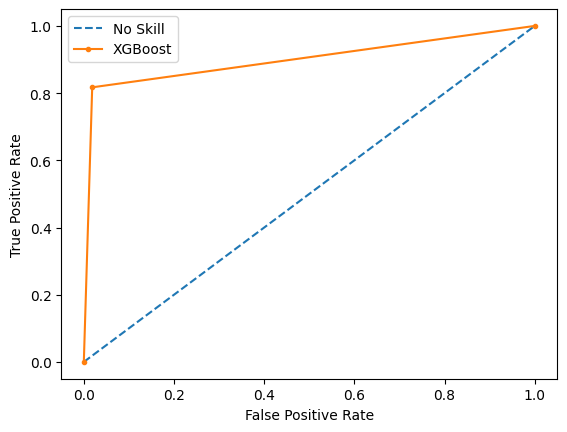

In [154]:
#ROC curve
ns_probs = [0 for _ in range(len(y_test))]
#ROC curve
ns_auc = roc_auc_score(y_test, ns_probs)
svc_auc = roc_auc_score(y_test, y_pred)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (svc_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

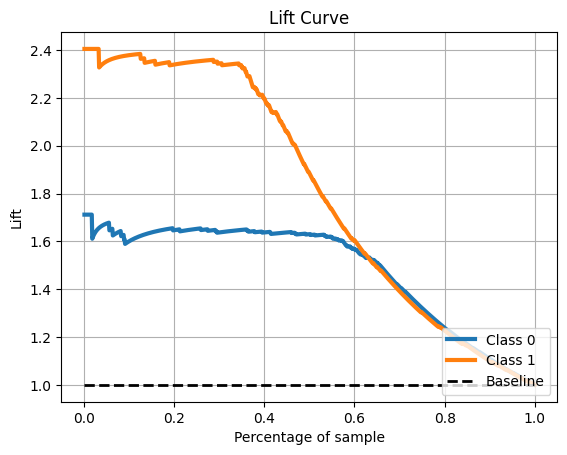

In [160]:
#Plotting LIFT curve below
skplt.metrics.plot_lift_curve(y_test, y_proba)
plt.show()

In terms of the overall predictive accuracy, KNN, logistic regression, decision tree, SVM, XGBoost and Neural Network were bult by using grid search and nested cross validation to evaluate the performance of each model. Neural Network has the best performance on training data with overall accuracy of 94.86% and an accuracy of 93.26% on testing data.

In terms of the average misclassification cost, a custom metric is defined for the problem with a 10:1 cost ratio for different misclassification errors, where the cost of false positive is set as 10 since predicting non-spam as spam is much more costly. Again, KNN, logistic regression, decision tree, SVM and XGBoost were bult by using grid search and nested cross validation to evaluate the performance of each model. XGBoost has outperformed other models with a average misclassification cost of 0.068 on training data and precision for spam is achieved by 97% on testing dataset.